In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
def plot_heatmap(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



# Multi-Headed Attention

Multi-headed attention is a crucial component of transformer architectures. It allows the model to focus on different parts of the input sequence simultaneously, providing richer contextual understanding and enabling the model to capture various relationships between words. (See self_attention.ipynb for a more detailed explanation of attention)

## Key Concepts:

### Expanding the Model’s Ability to Focus:

    Multi-headed attention allows the model to focus on different words in a sentence when determining the context for a specific word. For example, in the sentence "The animal didn’t cross the street because it was too tired," knowing which word "it" refers to is essential for accurate interpretation.

### Multiple Representation Subspaces:

    Each attention head learns to represent the input embeddings in a different subspace. This means that the model can capture different types of relationships and dependencies between words. In practice, a transformer model often uses multiple attention heads (e.g., 8) to achieve this effect.

![Head](../images/head1.png)

## Process of Multi-Headed Attention

### Compute Attention for Each Head:

For each attention head, compute separate Query, Key, and Value matrices from the input embeddings. This involves using different learned weight matrices for each head.

In [18]:
# Hyperparameters
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2  # Number of attention heads
head_dim = embedding_dim // num_heads  # Dimension of each head

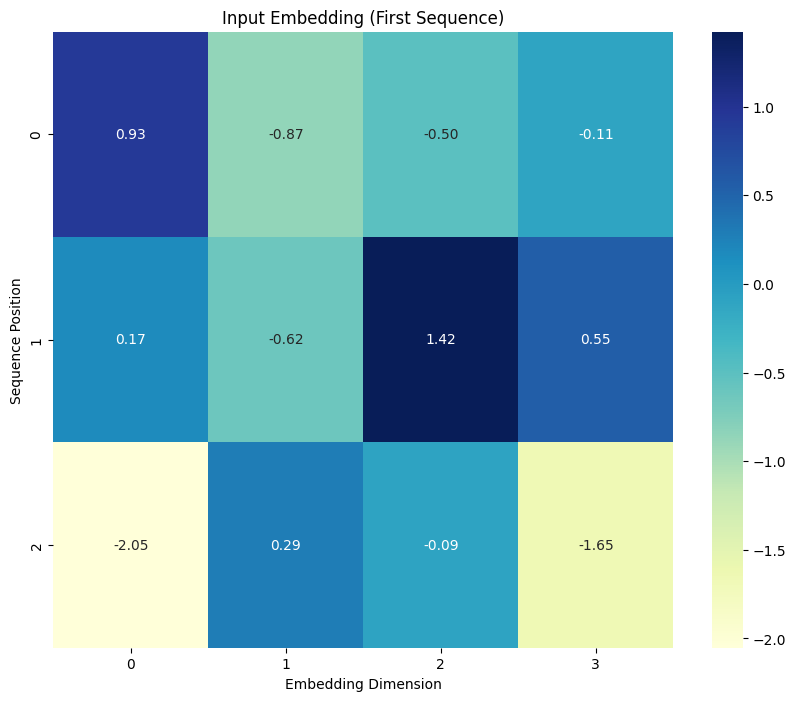

In [19]:

# Example input: Batch of 2 sequences, each with 3 tokens, embedding dimension of 4
X = torch.randn(batch_size, sequence_length, embedding_dim)

# Define learned weight matrices for Queries, Keys, and Values for each head
W_q = torch.randn(num_heads, embedding_dim, head_dim)  # (num_heads, 4, 2)
W_k = torch.randn(num_heads, embedding_dim, head_dim)  # (num_heads, 4, 2)
W_v = torch.randn(num_heads, embedding_dim, head_dim)  # (num_heads, 4, 2)
W_o = torch.randn(embedding_dim, embedding_dim)  # (4, 4) for the output

plot_heatmap(X[0].detach().numpy(), "Input Embedding (First Sequence)", "Embedding Dimension", "Sequence Position")


In [20]:

# Step 1: Calculate Q, K, V matrices for each head
Q = torch.stack([torch.matmul(X, W_q[i]) for i in range(num_heads)])
K = torch.stack([torch.matmul(X, W_k[i]) for i in range(num_heads)])
V = torch.stack([torch.matmul(X, W_v[i]) for i in range(num_heads)])


![head2](../images/head2.png)

In [21]:
# Step 2: Calculate attention scores for each head
dk = head_dim
attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(dk, dtype=torch.float32))
# (num_heads, batch_size, sequence_length, sequence_length)

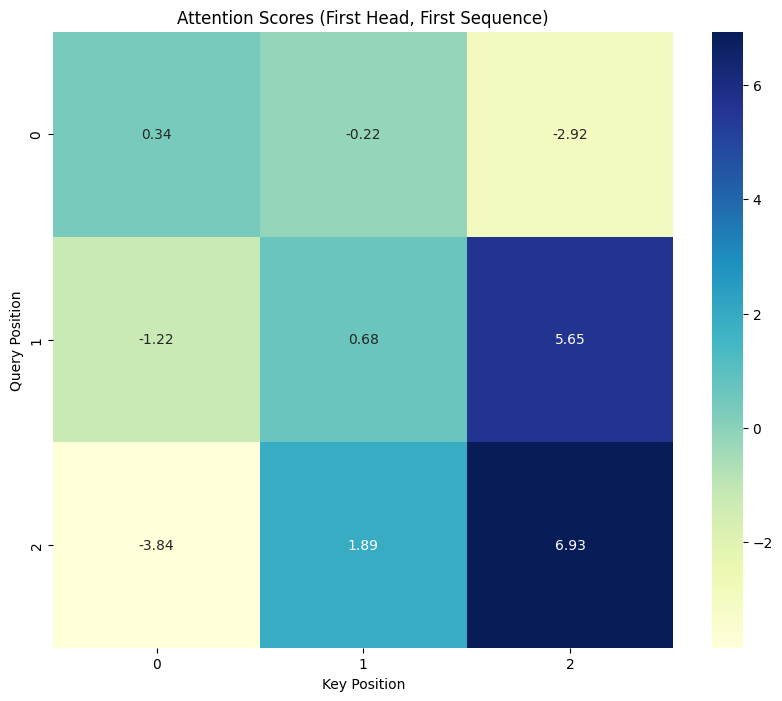

In [22]:
plot_heatmap(attention_scores[0, 0].detach().numpy(), "Attention Scores (First Head, First Sequence)", "Key Position", "Query Position")


In [23]:
# Step 3: Apply SoftMax along the sequence dimension to get attention weights for each head
attention_weights = F.softmax(attention_scores, dim=-1)  # (num_heads, batch_size, sequence_length, sequence_length)


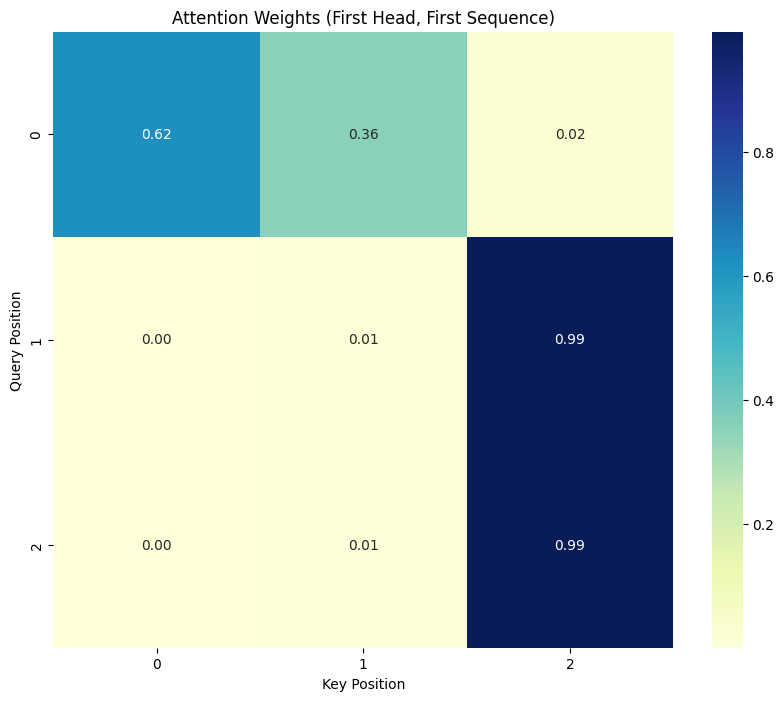

In [24]:
plot_heatmap(attention_weights[0, 0].detach().numpy(), "Attention Weights (First Head, First Sequence)", "Key Position", "Query Position")


In [25]:
# Step 4: Multiply the attention weights by the Value matrix to get the final attention output for each head
attention_outputs = torch.matmul(attention_weights, V)  # (num_heads, batch_size, sequence_length, head_dim)


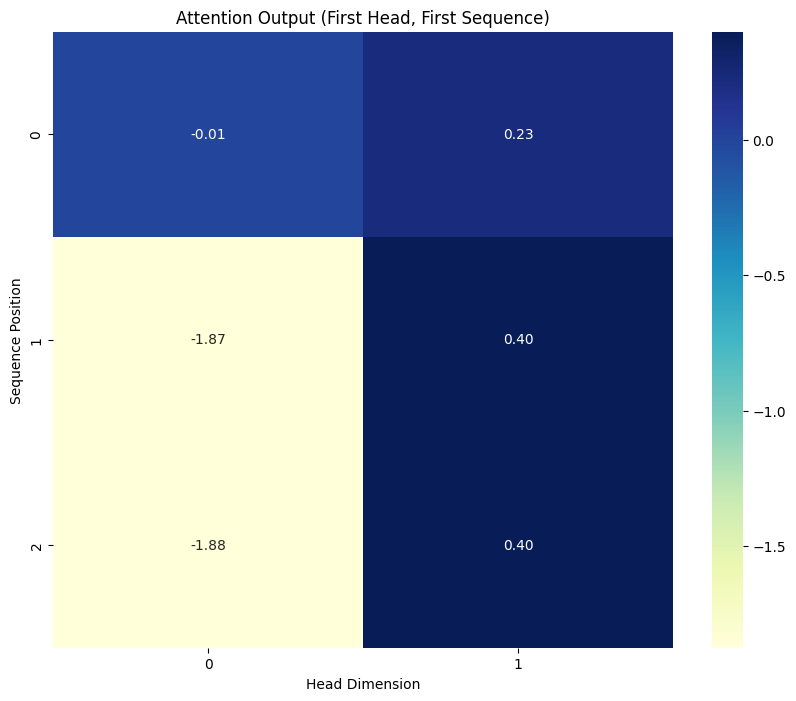

In [26]:
plot_heatmap(attention_outputs[0, 0].detach().numpy(), "Attention Output (First Head, First Sequence)", "Head Dimension", "Sequence Position")


However, the feed-forward layer is not expecting N matrices – it’s expecting a single matrix (a vector for each word). So we need a way to condense these eight down into a single matrix.

![head3](../images/head3.png)

In [27]:
# Step 5: Concatenate the outputs from all heads and apply a linear transformation
attention_outputs = attention_outputs.transpose(0, 1).contiguous().view(batch_size, sequence_length, -1)  # (batch_size, sequence_length, num_heads * head_dim)
output = torch.matmul(attention_outputs, W_o)  # (batch_size, sequence_length, embedding_dim)

# Output
print("Final output shape:", output.shape)
print("Final output:", output)

Final output shape: torch.Size([2, 3, 4])
Final output: tensor([[[-4.0255,  1.2068,  0.8729, -2.0809],
         [-0.0556, -2.2206, -1.9497, -0.4294],
         [ 2.6570,  0.0407, -1.5358,  0.2507]],

        [[ 1.8534, -0.3893,  0.2225,  0.9631],
         [ 0.7685,  0.9872,  2.0507,  1.2913],
         [-0.6112, -1.5512,  1.6138,  1.1250]]])


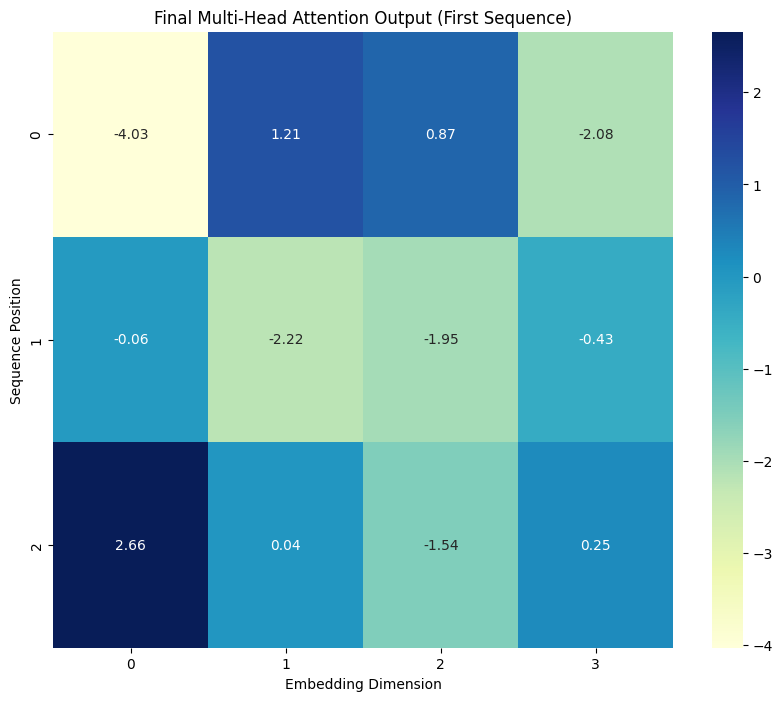

In [28]:
plot_heatmap(output[0].detach().numpy(), "Final Multi-Head Attention Output (First Sequence)", "Embedding Dimension", "Sequence Position")


To sum up the whole process in a single image

![sumup](../images/head4.png)

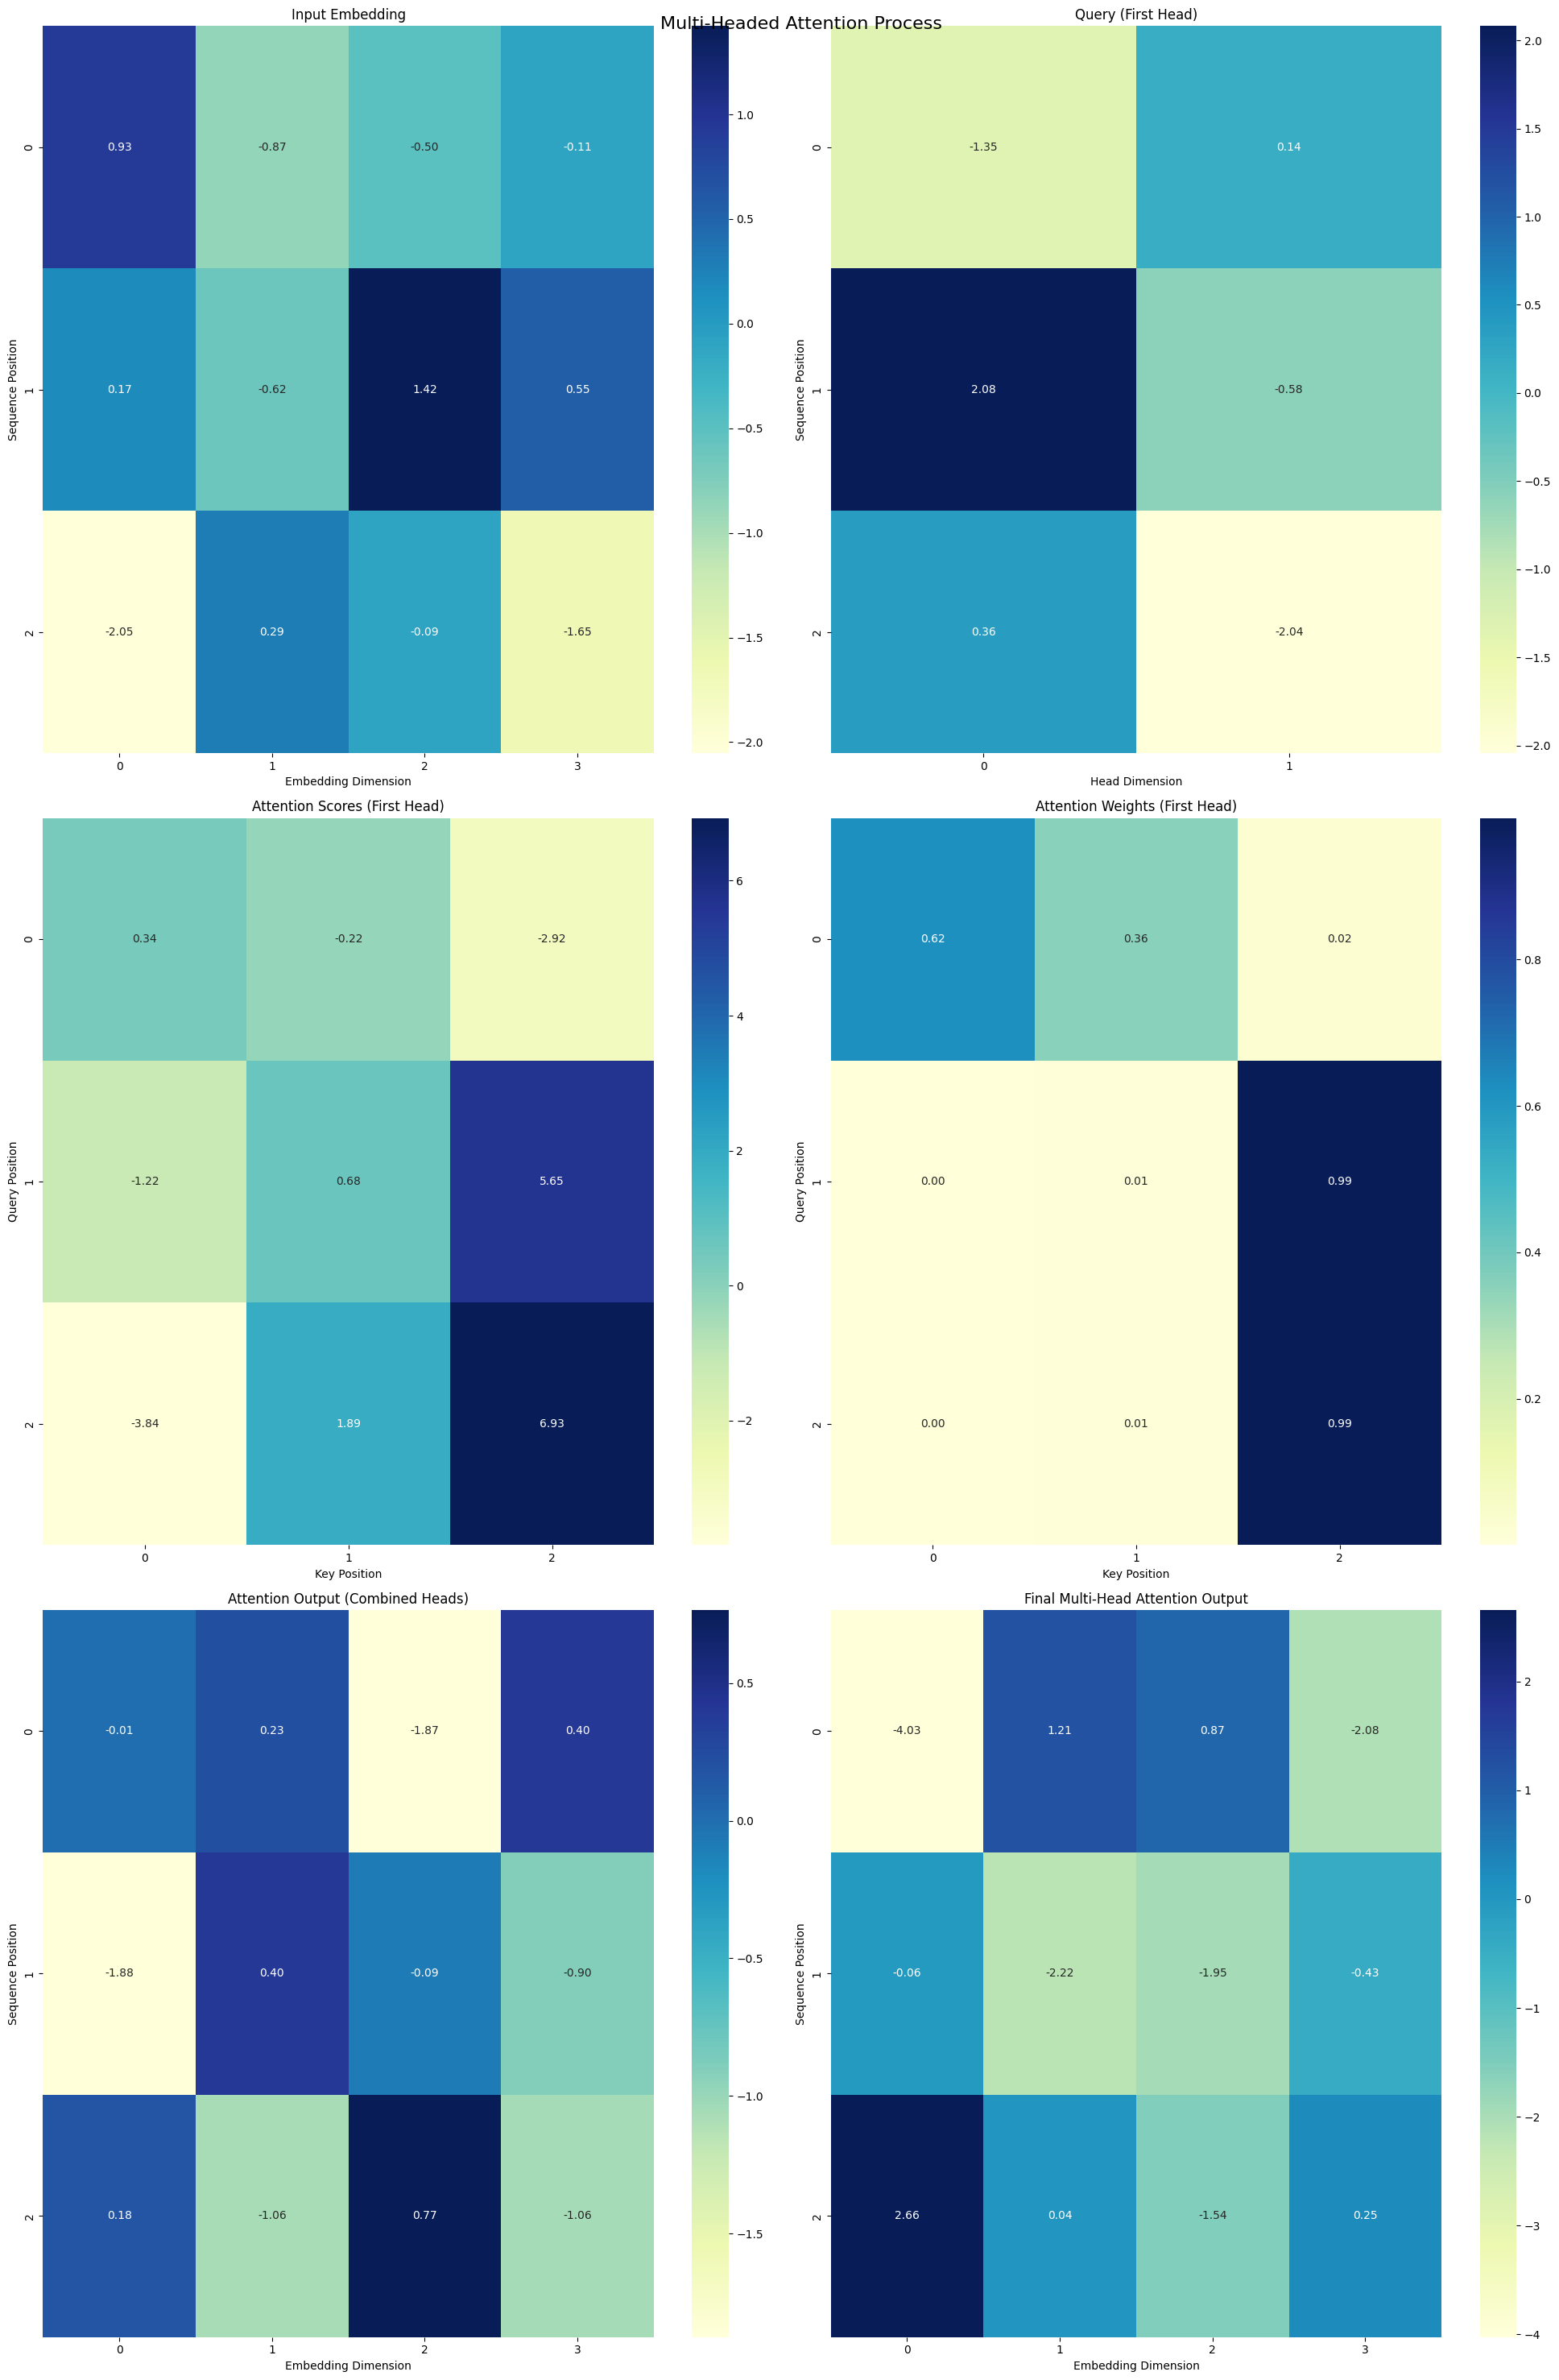

In [29]:

def plot_multi_head_attention_process():
    fig, axs = plt.subplots(3, 2, figsize=(20, 30))
    fig.suptitle("Multi-Headed Attention Process", fontsize=16)

    # Input
    sns.heatmap(X[0].detach().numpy(), ax=axs[0, 0], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[0, 0].set_title("Input Embedding")
    axs[0, 0].set_xlabel("Embedding Dimension")
    axs[0, 0].set_ylabel("Sequence Position")

    # Q, K, V
    sns.heatmap(Q[0, 0].detach().numpy(), ax=axs[0, 1], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[0, 1].set_title("Query (First Head)")
    axs[0, 1].set_xlabel("Head Dimension")
    axs[0, 1].set_ylabel("Sequence Position")

    # Attention Scores
    sns.heatmap(attention_scores[0, 0].detach().numpy(), ax=axs[1, 0], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[1, 0].set_title("Attention Scores (First Head)")
    axs[1, 0].set_xlabel("Key Position")
    axs[1, 0].set_ylabel("Query Position")

    # Attention Weights
    sns.heatmap(attention_weights[0, 0].detach().numpy(), ax=axs[1, 1], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[1, 1].set_title("Attention Weights (First Head)")
    axs[1, 1].set_xlabel("Key Position")
    axs[1, 1].set_ylabel("Query Position")

    # Attention Output (First Head)
    sns.heatmap(attention_outputs[0].detach().numpy(), ax=axs[2, 0], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[2, 0].set_title("Attention Output (Combined Heads)")
    axs[2, 0].set_xlabel("Embedding Dimension")
    axs[2, 0].set_ylabel("Sequence Position")

    # Final Output
    sns.heatmap(output[0].detach().numpy(), ax=axs[2, 1], cmap="YlGnBu", annot=True, fmt=".2f")
    axs[2, 1].set_title("Final Multi-Head Attention Output")
    axs[2, 1].set_xlabel("Embedding Dimension")
    axs[2, 1].set_ylabel("Sequence Position")

    plt.tight_layout()
    plt.show()

plot_multi_head_attention_process()

## Conclusion
 
In this notebook, we've implemented and visualized the multi-headed attention mechanism, a key component of transformer architectures. Let's recap the main steps and their significance:
 
1. **Input Embedding**: We start with input embeddings representing tokens in a high-dimensional space.
 
2. **Multiple Heads**: We create separate Query, Key, and Value projections for each attention head, allowing the model to focus on different aspects of the input simultaneously.
 
3. **Attention Scores**: We compute compatibility between queries and keys for each head, showing how much each token should attend to others from different perspectives.
 
4. **Attention Weights**: By applying softmax, we normalize the scores into probability distributions for each head, determining the weight of each token's contribution.
 
5. **Applying Attention**: We use these weights to create weighted sums of values for each head, effectively aggregating information from the sequence in different ways.
 
6. **Concatenation and Projection**: Finally, we combine information from all heads and project it to the output space, integrating the different perspectives captured by each head.
 
The visualizations help us understand how information flows and is transformed through the multi-headed attention mechanism. We can see how different heads can potentially focus on different aspects of the input, and how this information is combined in the final output.
 
Multi-headed attention is a powerful tool that allows models to capture rich, multi-faceted relationships within sequences, making it invaluable for tasks like machine translation, text summarization, and various other natural language processing tasks.